## Project 2
## Nick Murphy, nmurph03

In [1]:
import numpy as np
import pandas as pd
import csv
import sklearn
import statistics as stats
from sklearn.linear_model import LogisticRegression
import warnings
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import os,re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import tree

import graphviz

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickmurphy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickmurphy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Helpful Functions from past homeworks and projects

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    for i in range(len(ytrue_N)):
        if yhat_N[i] == 1:
            if ytrue_N[i] == yhat_N[i]:
                TP+=1
            elif ytrue_N[i] != yhat_N[i]:
                FP+=1
        elif yhat_N[i] == 0:
            if ytrue_N[i] == yhat_N[i]:
                TN+=1
            elif ytrue_N[i] != yhat_N[i]:
                FN+=1
    return TP, TN, FP, FN

In [3]:
def accuracy(data, checker):
    TP, TN, FP, FN = calc_TP_TN_FP_FN(data, checker)
    acc = float((TP + TN)/(TP + TN + FP + FN))
    return acc

In [4]:
def make_folds(num_folds, x, y):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    foldlen = int(len(x)/num_folds)
    start = 0
    # TODO: Complete method to generate partition into folds.
    for k in range(num_folds):
        x_folds.append(x[start:start + foldlen])
        y_folds.append(y[start:start + foldlen])
        start += foldlen
    
    return x_folds, y_folds

In [5]:
def mymake_folds(num_folds,x_train, y_train):
    print("Inside mymake_folds")
    i = 0
    step = int(x_train.shape[0] / num_folds)
    x_folds = list()
    y_folds = list()
    for k in range(num_folds):
        x_folds.append(x_train[i:i+step])
        y_folds.append(y_train[i:i+step])
        i += step
    
    # TODO: Complete method to generate partition into folds.
    
    return np.array(x_folds), np.array(y_folds)

In [6]:
def pop_row(arr, index):
    popped = arr[index]
    result = np.vstack((arr[:index], arr[index + 1:]))
    return result, popped

In [7]:
def cat(data):
    data_final = [y for x in data for y in x]
    return data_final

In [8]:
def print_cross_in_table(trainingerr, testingerr, poly):
    d = {'Degree': poly, 'Average Testing Error': testingerr, 'Average Training Error': trainingerr}
    df = pd.DataFrame(data = d)
    print(df)

In [9]:
def cross_validate(x_folds, y_folds, polynomials=list()):
    k=5
    print("Made it into cross_validate")
    testingerr, trainingerr = mytest_polynomials(poly,x_folds,y_folds)
    print("Finished mytest_polynomials")
    plt.plot(poly, testingerr, color='red', label = 'Testing Error')
    plt.plot(poly, trainingerr, color='blue', label = 'Training Error')
    plt.title('K Fold Cross Validation Training Error and Testing Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Average Error')
    plt.legend()
    plt.show()
    print_cross_in_table(trainingerr, testingerr, poly)

In [10]:
def mytest_polynomials(polynomials,x_folds,y_folds):
    print("Made it into mytest_polynomials")
    test_score = []
    train_score = []
    k = 5
    for deg in polynomials:
        print("Curr degree == ", deg)
        test_error = 0
        train_error = 0
        for i in range(k):
            print("Curr i == ", i)
            training_x = x_folds.copy()
            testing_x = training_x[i]
            training_x = training_x - testing_x
            training_y = y_folds.copy()
            testing_y = training_y[i]
            training_y = training_y - testing_y
            poly = PolynomialFeatures(degree = deg)
            model = LinearRegression()
            cat_X = cat(training_x)
            cat_Y = cat(training_y)
            new_X = poly.fit_transform(cat_X)
            model.fit(new_X, cat_Y)
            y_train_predict = model.predict(new_X)
            y_test_predict = model.predict(poly.fit_transform(testing_x))
            train_error += mean_squared_error(cat_Y, y_train_predict)
            test_error += mean_squared_error(testing_y, y_test_predict)
        test_score.append(test_error/k)
        train_score.append(train_error/k) 
    return test_score, train_score

In [11]:
def cross_ridge_validation(degree):
    regularization = np.logspace(-2, 2, base=10, num=50)
    ridge_train_err, ridge_test_err = ridge_polynomials(x_folds, y_folds, degree, regularization)
    plt.xscale('log')
    plt.plot(regularization,ridge_train_err, color='purple',label = "Training Error")
    plt.plot(regularization,ridge_test_err, color='orange', label = "Testing Error")
    plt.title('Ridge Regression with degree ' + str(degree))
    plt.xlabel('Regulization Strength')
    plt.ylabel('Average Error')
    plt.legend()
    plt.show()
    print_cross_in_table(ridge_train_err, ridge_test_err)

In [12]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [13]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [14]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

In [15]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

In [16]:
def find_false_classifications(x_train, y_train, x_test, y_test, test_predict_y):
    false_positives = []
    false_negatives = []
    for i in range(len(test_predict_y)):
        if test_predict_y[i] == 1 and y_test[i] == 0:
            vert_1 = convert(x_test[i], 28)
            #print(vert_1)
            false_positives.append(vert_1)
        if test_predict_y[i] == 0 and y_test[i] == 1:
            vert_2 = convert(x_test[i], 28)
            #print(vert_2)
            false_negatives.append(vert_2)
    return false_positives, false_negatives

In [17]:
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)



In [54]:
for text in train_text_list:
    print(text)

Oh and I forgot to also mention the weird color effect it has on your phone.
THAT one didn't work either.
Waste of 13 bucks.
Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
None of the three sizes they sent with the headset would stay in my ears.
Worst customer service.
The Ngage is still lacking in earbuds.
It always cuts out and makes a beep beep beep sound then says signal failed.
the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!!
Very disappointed in AccessoryOne.
Basically the service was very bad.
Bad Choice.
The only thing that disappoint me is the infra red port (irda).
horrible, had to switch 3 times.
It feels poorly constructed, the menus are difficult to navigate, and the buttons are so recessed that it is difficult to push them.
Don't make the same mistake I did.
Muddy, low quality sound, and the casing around the wire's insert was poorly super glued and slid off.
I advise EVERYONE

This is an Outstanding little restaurant with some of the Best Food I have ever tasted.
Great place to have a couple drinks and watch any and all sporting events as the walls are covered with TV's.
Pretty cool I would say.
The flair bartenders are absolutely amazing!
The croutons also taste homemade which is an extra plus.
the potatoes were great and so was the biscuit.
So they performed.
It's worth driving up from Tucson!
Best tacos in town by far!!
The chips and salsa were really good, the salsa was very fresh.
Our server was super nice and checked on us many times.
The cocktails are all handmade and delicious.
They know how to make them here.
We made the drive all the way from North Scottsdale... and I was not one bit disappointed!
Great service and food.
We loved the biscuits!!!
Definitely worth venturing off the strip for the pork belly, will return next time I'm in Vegas.
They really want to make your experience a good one.
Favorite place in town for shawarrrrrrma!!!!!!
The burge

In [18]:
stops = set(nltk.corpus.stopwords.words('english'))
print(stops)

{'needn', 'wouldn', "weren't", 're', 'nor', 'itself', 's', 'them', 'such', 'didn', 'just', "hasn't", 'hadn', 'any', 'did', 'her', 'do', 'she', 'won', 'ours', 'into', 'himself', "mightn't", 'if', 'a', 'why', 'not', 'too', 'we', "should've", "shan't", "shouldn't", 'until', "didn't", 'yourself', 'how', 'myself', 'he', 'have', 'at', 'before', 'they', 'it', 'm', 'as', 'having', 'll', 'hasn', 'more', 'yourselves', 'to', 'up', 'been', 'very', 'same', 'herself', 'own', 'other', "needn't", 'an', 'whom', 'doing', 'will', 'were', 'd', 'mightn', 'or', "you'd", 'had', 'then', 'ma', 'weren', 'this', 'both', 'don', 'yours', 'which', 'most', 'your', 've', 'couldn', 'but', 'should', 'and', 'some', 'all', 'here', 'my', "haven't", "won't", 'against', "isn't", 'once', 'am', 'through', 'below', 'off', 'him', 'has', 'each', 'that', 'by', 'out', 'its', 'themselves', 'than', 'y', 'aren', "that'll", 'only', 'doesn', 'does', 'is', 'between', 'so', "she's", 'their', 'over', 'while', 'hers', 'ain', 'o', "you've",

In [19]:
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''

In [20]:
def remove_punctuation(line):
    res = re.sub(r'[^\w\s]', '', line)
    return res

In [21]:
def clean_line(line):
    tokened = word_tokenize(line)
    filtered_sentence = [w for w in tokened if not w in stops] 
    filtered_sentence = [] 
    for w in tokened: 
        if w not in stops: 
            filtered_sentence.append(w) 
    return remove_punctuation(str(filtered_sentence))

In [22]:
l = clean_line(train_text_list[12])
print(train_text_list[12])
print(l)

The only thing that disappoint me is the infra red port (irda).
The thing disappoint infra red port  irda  


In [43]:
stop = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}


In [44]:
# Preprocess Data
from nltk.stem.porter import PorterStemmer
def preprocess(review_arr):
    processed = []

  # case characters by converting them all to lowercase
    for text in review_arr:
        processed.append(text)

  # negation handling by converting apostrophes to standard lexicon 
    negation = []
    for text in processed:
        words = text.split()
        reformed = [stop[word] if word in stop else word for word in words]
        reformed = " ".join(reformed)
        negation.append(reformed)

  # tokenize data by converting text to tokens
    tokenized = []
    for text in negation:
        tokenized.append(word_tokenize(text))

  # remove stopwords from sentences (words that are most commonly occurring, but not
  # relevant in the context of the data)
  # we use english stopwords here, which may not be relevant in the context of foreign words
    stop_words = set(stopwords.words('english'))
    for text in tokenized:
        text = [i for i in text if not i in stop_words]
  
  # remove stand-alone punctuation
    stripped = []
    for text in tokenized:
        words = [word for word in text if word.isalpha()]
        stripped.append(words)

  # stemming/lemmatization finds the base or dictionary form of the word known as the lemma
  # using vocabulary and morphological analysis
  # use gensim package -- which takes into account part-of-speech as well.
    lemmas = []
    porter = PorterStemmer()
    for text in stripped:
        lemmafied = []
        for t in text:
            lemmafied.append(porter.stem(t))
        lemmas.append(lemmafied)

    return lemmas

In [45]:
def clean_list(data):
    cleaned = []
    for i in data:
        res = clean_line(i)
        cleaned.append(res)
    return cleaned

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
x_test_clean = clean_list(test_text_list)
x_train_clean = clean_list(train_text_list)
x_tot = x_test_clean + x_train_clean
count_vectorizer = CountVectorizer(analyzer = "word")
x = count_vectorizer.fit_transform(x_tot)
x = x.toarray()
x_train = x[:2400]
x_test = x[2400:]
print(x_train.shape)
print(x_test.shape)

(2400, 5232)
(600, 5232)


In [58]:
x_test_clean = clean_list(test_text_list)
x_train_clean = clean_list(train_text_list)
print(test_text_list[15])
print(x_test_clean[15])

Don't buy this product.
Do nt buy product 


In [28]:
def tr_te_split(data, l):
    te = data[:l]
    tr = data[l:]
    return tr, te

In [17]:
# Simplest basic tokenizing and counting:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x_tot = x_test_clean + x_train_clean
leng = len(x_train_clean)
count_vectorizer = CountVectorizer(analyzer = "word")
x = count_vectorizer.fit_transform(x_tot)
x = x.toarray()
x_train = x[:2400]
x_test = x[2400:]

In [30]:
clf = LogisticRegression(solver='liblinear').fit(x_train, y_train)

y_te = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_te)

In [104]:
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import tree

In [32]:
# MLP Classifier
import time
n_runs = 16
start_time_sec = time.time()
LBFGS_RELU_loss = []
LBFSG_RELU_res = []
for i in range(n_runs):
    mlp_lbfgs = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=i,
        )
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_lbfgs.fit(x_train, y_train)
    elapsed_time_sec = time.time() - start_time_sec
    print('finished LBFGS run %2d/%d after %6.1f sec | %3d iters | loss %.3f' % (
        i, n_runs, elapsed_time_sec,
        len(mlp_lbfgs.loss_curve_),
        mlp_lbfgs.loss_))
    LBFGS_RELU_loss.append(mlp_lbfgs.loss_curve_)
    LBFSG_RELU_res.append(mlp_lbfgs)

finished LBFGS run  0/16 after    1.8 sec |  37 iters | loss 0.494
finished LBFGS run  1/16 after    5.0 sec |  86 iters | loss 0.241
finished LBFGS run  2/16 after    5.5 sec |  11 iters | loss 0.635
finished LBFGS run  3/16 after    5.9 sec |  10 iters | loss 0.665
finished LBFGS run  4/16 after    6.1 sec |   4 iters | loss 0.689
finished LBFGS run  5/16 after    7.7 sec |  41 iters | loss 0.443
finished LBFGS run  6/16 after    8.8 sec |  26 iters | loss 0.506
finished LBFGS run  7/16 after   16.3 sec | 200 iters | loss 0.124
finished LBFGS run  8/16 after   23.8 sec | 200 iters | loss 0.129
finished LBFGS run  9/16 after   31.2 sec | 200 iters | loss 0.120
finished LBFGS run 10/16 after   38.6 sec | 200 iters | loss 0.135
finished LBFGS run 11/16 after   46.1 sec | 200 iters | loss 0.130
finished LBFGS run 12/16 after   53.7 sec | 200 iters | loss 0.123
finished LBFGS run 13/16 after   61.1 sec | 200 iters | loss 0.169
finished LBFGS run 14/16 after   68.4 sec | 200 iters | loss 0

In [54]:
mlp_relu = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=5000, tol=1e-6,
        random_state=9,
        )
mlp_relu.fit(x_train, y_train)
y_te = clf.predict(x_test)
#np.savetxt('yproba1_test.txt', y_te)

NameError: name 'clf' is not defined

In [60]:
print(y_pred.shape)

(600,)


In [61]:
mlp_relu = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=5000, tol=1e-6,
        random_state=9,
        )
with warnings.catch_warnings(record=True) as warn_list:
    mlp_relu.fit(x_train, y_train)
    y_pred = mlp_relu.predict(x_test)
    counter = 0.0
    for r in range(len(y_pred)):
        if y_train[r] != y_pred[r]:
                counter += 1
print((1-counter/x_train.shape[0]))

0.85625


In [64]:
y_pred = mlp_relu.predict(x_test)
counter = 0.0
for r in range(len(y_pred)):
    if y_train[r] != y_pred[r]:
        counter += 1
print((1-counter/x_train.shape[0]))

0.85625


In [117]:
def MLP_class(x_train, y_train, x_test, activation):
    X = x_train
    y = y_train
    stds = []
    penalty_acc = []
    penalty_loss = []
    stds = []
    k = 5
    n_runs = 50
    kf = KFold(n_splits=k, random_state=None)
    for train_index , test_index in kf.split(X):
        x_train , x_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        LBFGS_RELU_loss = []
        LBFSG_RELU_res = []
        LBFGS_RELU_i = []
        mod_accuracy = []
        mod_loss = []
        for i in range(n_runs):
            mlp_lbfgs = MLPClassifier(
                hidden_layer_sizes=[2],
                activation=activation,
                alpha=0.0001,
                max_iter=200, tol=1e-6,
                random_state=i,
                )
            if i % 10 == 0:
                print("Almost there", i)
            with warnings.catch_warnings(record=True) as warn_list:
                mlp_lbfgs.fit(x_train, y_train)
            y_pred = mlp_lbfgs.predict(x_test)
            counter = 0.0
            for r in range(len(y_test)):
                if y_test[r] != y_pred[r]:
                    counter += 1
            LBFSG_RELU_res.append(1-counter/x_train.shape[0])
            LBFGS_RELU_loss.append(sklearn.metrics.log_loss(y_test,y_pred))
        penalty_acc.append(LBFSG_RELU_res)
        penalty_loss.append(LBFGS_RELU_loss)
        std = stats.stdev(LBFSG_RELU_res)
        stds.append(std)
    plt.subplot(211)
    rands = [_ for _ in range(1,51)]
    std = stats.mean(stds)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    mins = find_min(penalty_loss)
    maxs = find_max(penalty_acc)
    plt.xlabel('random_state')
    plt.ylabel('logistic loss')
    plt.plot(rands,penalty_loss[0], color='blue',label = "Log Loss when k = 0")
    plt.plot(rands,penalty_loss[1], color='red',label = "Log Loss when k = 1")
    plt.plot(rands,penalty_loss[2], color='orange',label = "Log Loss when k = 2")
    plt.plot(rands,penalty_loss[3], color='black',label = "Log Loss when k = 3")
    plt.plot(rands,penalty_loss[4], color='grey',label = "Log Loss when k = 4")
    plt.legend()
    plt.show()
    plt.xlabel('random_state')
    plt.ylabel('Accuracy')
    plt.plot(rands,penalty_acc[0], color='blue',label = "Accuracy when k = 0")
    plt.plot(rands,penalty_acc[1], color='red',label = "Accuracy when k = 1")
    plt.plot(rands,penalty_acc[2], color='orange',label = "Accuracy when k = 2")
    plt.plot(rands,penalty_acc[3], color='black',label = "Accuracy when k = 3")
    plt.plot(rands,penalty_acc[4], color='grey',label = "Accuracy when k = 4")
    plt.legend()
    plt.show()
    print("Best random_state for MLP: %.7f" % rands[np.argmax(maxs)]) # TODO
    print("Log-loss at best random_state: %.4f" % min(mins))
    print("Accuracy under the best random_state: %.4f" % maxs[np.argmax(maxs)])

Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Standard deviation of models: 0.006548116236843003


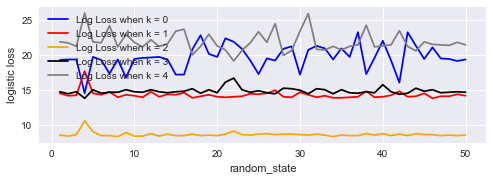

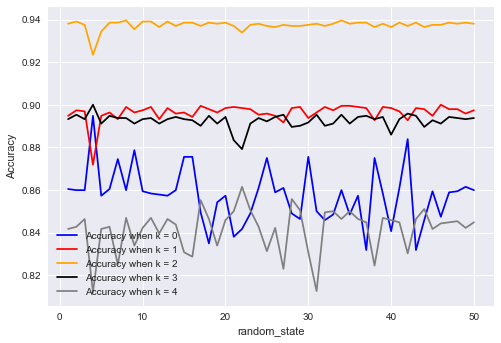

Best random_state for MLP: 3.0000000
Log-loss at best random_state: 8.3469
Accuracy under the best random_state: 0.9396


In [118]:
vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tr = []
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

x_te = [] 
for text in x_test_clean:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
MLP_class(x_train, y_train, x_test, 'logistic')
MLP_class(x_train, y_train, x_test, 'relu')

Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Standard deviation of models: 0.014944164030228363


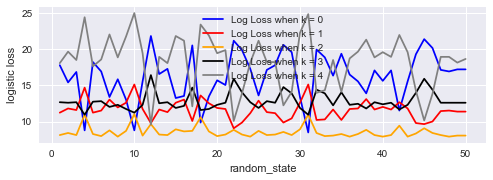

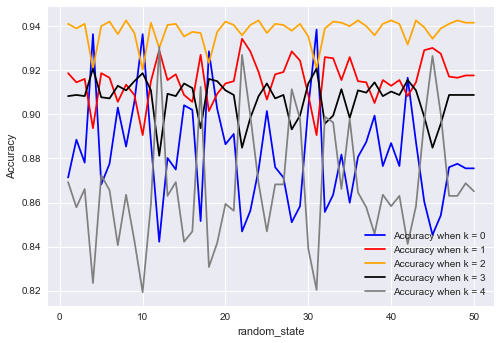

Best random_state for MLP: 3.0000000
Log-loss at best random_state: 7.9152
Accuracy under the best random_state: 0.9427


In [119]:
MLP_class(x_train, y_train, x_test, 'relu')

In [144]:
def mySVM2(x_train, x_test, y_train):
    C_grid = np.logspace(-9, 6, 31)
    penalty_acc = []
    penalty_loss = []
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    X = x_train
    y = y_train
    stds = []
    penalty_acc = []
    penalty_loss = []
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    for train_index , test_index in kf.split(X):
        print("cunt")
        x_train , x_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        mini_acc = []
        mini_loss = []
        for c in C_grid:
            clf = svm.SVC(random_state=3, C=c)
            clf.fit(x_train, y_train)
            test_predict = clf.predict(x_test)
            mini_acc.append(clf.score(x_test,y_test))
            mini_loss.append(sklearn.metrics.log_loss(y_test, test_predict))
        std = stats.stdev(mini_acc)
        stds.append(std)
        penalty_acc.append(mini_acc)
        penalty_loss.append(mini_loss)
    std = stats.mean(stds)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    mins = find_min(penalty_loss)
    maxs = find_max(penalty_acc)
    plt.xscale('log')
    plt.xlabel('log10(C)')
    plt.ylabel('logistic loss')
    plt.plot(C_grid,penalty_loss[0], color='blue',label = "Log Loss when k = 0")
    plt.plot(C_grid,penalty_loss[1], color='red',label = "Log Loss when k = 1")
    plt.plot(C_grid,penalty_loss[2], color='orange',label = "Log Loss when k = 2")
    plt.plot(C_grid,penalty_loss[3], color='black',label = "Log Loss when k = 3")
    plt.plot(C_grid,penalty_loss[4], color='grey',label = "Log Loss when k = 4")
    plt.legend()
    plt.show()
    plt.plot(C_grid,penalty_acc[0], color='blue',label = "Accuracy when k = 0")
    plt.plot(C_grid,penalty_acc[1], color='red',label = "Accuracy when k = 1")
    plt.plot(C_grid,penalty_acc[2], color='orange',label = "Accuracy when k = 2")
    plt.plot(C_grid,penalty_acc[3], color='black',label = "Accuracy when k = 3")
    plt.plot(C_grid,penalty_acc[4], color='grey',label = "Accuracy when k = 4")
    plt.legend()
    plt.show()
    print("Best C-value for SVM: %.7f" % C_grid[np.argmin(mins)]) # TODO
    print("Log-loss at best C-value: %.4f" % min(mins))
    print("Accuracy of model using best C-value: %.7f" % max(maxs))

In [48]:
#vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = clean_list(test_text_list)
x_train_clean = clean_list(train_text_list)
x_tr = []
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

x_te = [] 
for text in x_test_clean:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
print(x_train.shape)
print(x_test.shape)

(2400, 3417)
(600, 3417)


In [52]:
mlp_relu = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=5000, tol=1e-6,
        random_state=9,
        )
mlp_relu.fit(x_train, y_train)
y_te = mlp_relu.predict(x_test)
from sklearn.model_selection import cross_val_score
cross_val_score(mlp_relu, x_train,y_train)

NameError: name 'cross_val_score' is not defined

In [53]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp_relu, x_train,y_train)

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multila

array([0.5       , 0.47708333, 0.49791667, 0.5       , 0.5       ])

cunt
cunt
cunt
cunt
cunt
Standard deviation of models: 0.15851537555280992


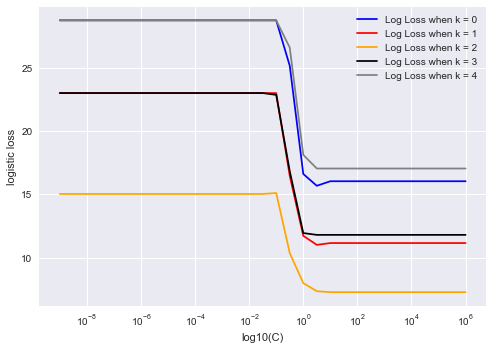

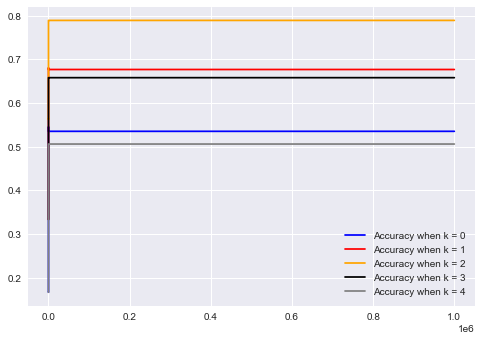

Best C-value for SVM: 0.0000000
Log-loss at best C-value: 7.2676
Accuracy of model using best C-value: 0.7895833


In [146]:
vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tr = []
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

x_te = [] 
for text in x_test_clean:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
mySVM2(x_train, x_test, y_train)

In [37]:
# SVM
clf = svm.SVC(random_state=4)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)

In [38]:
# Tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)

In [38]:
count_vectorizer = CountVectorizer(analyzer = "word",     
                             max_features = 6000,
                                  max_df = 0.75)
x = count_vectorizer.fit_transform(x_tot)
x = x.toarray()
#x_train, x_test = tr_te_split(x, leng)
x_train = x[:2400]
x_test = x[2400:]

In [39]:
clf = LogisticRegression(solver='liblinear').fit(x_train, y_train)

y_te = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_te)

In [40]:
count_vectorizer = CountVectorizer(analyzer = "word",     
                             max_features = 6000,
                                  min_df = 0.1)
x = count_vectorizer.fit_transform(x_tot)
x = x.toarray()
#x_train, x_test = tr_te_split(x, leng)
x_train = x[:2400]
x_test = x[2400:]

In [41]:
clf = LogisticRegression(solver='liblinear').fit(x_train, y_train)

y_te = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_te)

In [93]:
def find_min(arr):
    mins = []
    for i in arr:
        mins.append(min(i))
    return mins

In [94]:
def find_max(arr):
    mins = []
    for i in arr:
        mins.append(max(i))
    return mins

In [112]:
def myfind_best_pen(x_train, y_train, x_test):
    C_grid = np.logspace(-9, 6, 31)
    penalty_acc = []
    penalty_loss = []
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression(solver= 'liblinear')
    X = x_train
    y = y_train
    stds = []
    penalty_acc = []
    penalty_loss = []
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    for train_index , test_index in kf.split(X):
        x_train , x_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        mini_acc = []
        mini_loss = []
        for C in C_grid:
            model_2 = LogisticRegression(solver='liblinear', C=C).fit(x_train, y_train)
            test_predict = model_2.predict_proba(x_test)
            mini_acc.append(model_2.score(x_test,y_test))
            mini_loss.append(sklearn.metrics.log_loss(y_test, test_predict))
        std = stats.stdev(mini_acc)
        stds.append(std)
        penalty_acc.append(mini_acc)
        penalty_loss.append(mini_loss)
    
    std = stats.mean(stds)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    mins = find_min(penalty_loss)
    maxs = find_max(penalty_acc)
    plt.xscale('log')
    plt.xlabel('log10(C)')
    plt.ylabel('logistic loss')
    plt.plot(C_grid,penalty_loss[0], color='blue',label = "Log Loss when k = 0")
    plt.plot(C_grid,penalty_loss[1], color='red',label = "Log Loss when k = 1")
    plt.plot(C_grid,penalty_loss[2], color='orange',label = "Log Loss when k = 2")
    plt.plot(C_grid,penalty_loss[3], color='black',label = "Log Loss when k = 3")
    plt.plot(C_grid,penalty_loss[4], color='grey',label = "Log Loss when k = 4")
    plt.legend()
    plt.show()
    plt.plot(C_grid,penalty_acc[0], color='blue',label = "Accuracy when k = 0")
    plt.plot(C_grid,penalty_acc[1], color='red',label = "Accuracy when k = 1")
    plt.plot(C_grid,penalty_acc[2], color='orange',label = "Accuracy when k = 2")
    plt.plot(C_grid,penalty_acc[3], color='black',label = "Accuracy when k = 3")
    plt.plot(C_grid,penalty_acc[4], color='grey',label = "Accuracy when k = 4")
    plt.legend()
    plt.show()
    print("Best C-value for LR: %.7f" % C_grid[np.argmin(mins)]) # TODO
    print("Log-loss at best C-value: %.4f" % min(mins))
    print("Accuracy of model using best C-value: %.7f" % max(maxs))

In [158]:
def myfit_logistic(x_train, y_train, x_test):
    acc_scores = []
    log_loss = []
    weights = []
    for max_iter in range(1,41):
        model = LogisticRegression(solver = 'liblinear', max_iter = max_iter, C = 1.000).fit(x_train, y_train)
        weights.append(model.coef_[0][0])
        acc_scores.append(model.score(x_train, y_train))
        y_pred = model.predict_proba(x_train)
        log_loss.append(sklearn.metrics.log_loss(y_train, y_pred))
    std = stats.stdev(acc_scores)
    print("Standard deviation of models:", std)
    print("done building models")
    acc = plt.figure()
    plt.xlabel('Max_Iter Value (i)')
    plt.ylabel('Accuracy')
    plt.plot([_ for _ in range(1,41)], acc_scores, color = 'red', label = 'Accuracy Curve')
    plt.legend()
    plt.show()
    print("Max Accuracy Score: ", max(acc_scores))
    print("Max_Iter of max accuracy score: ", acc_scores.index(max(acc_scores)))
    
    loss = plt.figure()
    plt.xlabel('Max_Iter Value(i)')
    plt.ylabel('Logistic Loss')
    plt.plot([_ for _ in range(1,41)],log_loss, color='blue',label = "Log-Loss Curve")
    plt.legend()
    plt.show()
    print("Min Logistic Loss: ", min(log_loss))
    print("Max_Iter of min logistic loss: ", log_loss.index(min(log_loss)))
    return acc, loss

In [79]:
def mymake_folds3(num_folds,x_train, y_train):
    print("Inside mymake_folds")
    i = 0
    print(x_train.shape)
    step = int(x_train.shape[0] / num_folds)
    x_folds = list()
    y_folds = list()
    for k in range(num_folds):
        x_folds.append(x_train[i:i+step])
        y_folds.append(y_train[i:i+step])
        i += step
    
    # TODO: Complete method to generate partition into folds.
    
    return np.array(x_folds), np.array(y_folds)

In [74]:
def vectorizer(sentence):
    sent_vec = np.zeros(50)
    numw = 0
    for w in sentence:
        try: 
            vc = word2vec[w]
            vc = [i * tfidf[w] for i in vc]
            vc=vc[0:50]
            sent_vec = np.add(sent_vec, vc)
            numw+=1
        except:
            pass
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

In [73]:
te_text_list = x_test_df['text'].values.tolist()
tr_text_list = x_train_df['text'].values.tolist()
X_train_pre = []
for sentence in preprocess(tr_text_list):
    X_train_pre.append(vectorizer(sentence))

X_train = []
for sentence in X_train_pre:
    arr = []
    for word in sentence:
        if np.isnan(word):
            arr.append(0)
        else:
            arr.append(word)
        X_train.append(arr)

x_train = np.array(X_train)

X_test_pre = []

for sentence in preprocess(te_text_list):
    X_test_pre.append(vectorizer(sentence))

X_test = []
for sentence in X_test_pre:
    arr = []
    for word in sentence:
        if np.isnan(word):
            arr.append(0)
        else:
            arr.append(word)
    X_test.append(arr)

x_test = np.array(X_test)

print(x_test.shape)
print(x_train.shape)

<ipython-input-72-d489885e9cdc>:13: RuntimeWarning: invalid value encountered in true_divide
  return sent_vec / np.sqrt(sent_vec.dot(sent_vec))


(600, 50)
(120000, 50)


Standard deviation of models: 0.14632646060890242


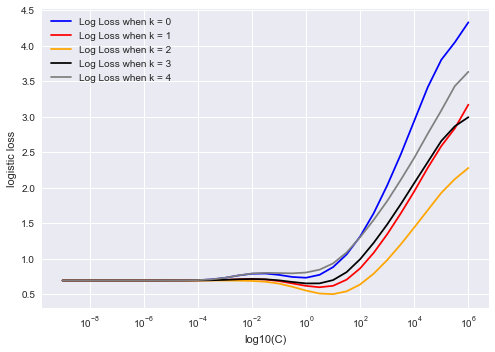

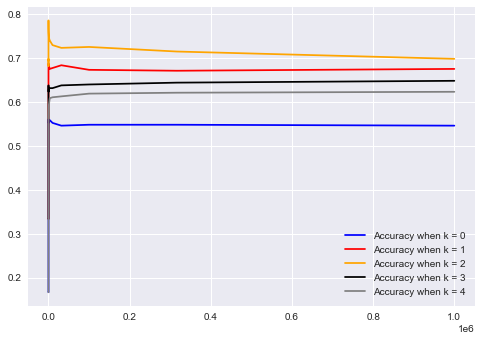

Best C-value for LR: 0.0000000
Log-loss at best C-value: 0.5008
Accuracy of model using best C-value: 0.7854167


In [149]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tr = []
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

x_te = [] 
for text in x_test_clean:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)

myfind_best_pen(x_train, y_train, x_test)

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurph

Standard deviation of models: 0.00014881715487149118
done building models


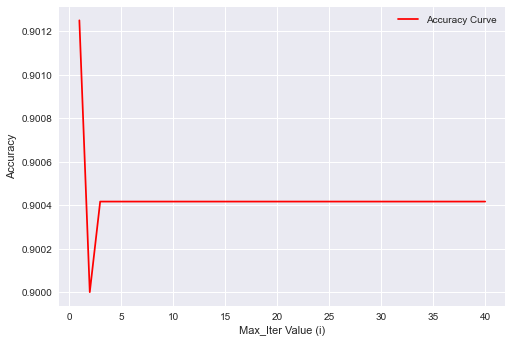

Max Accuracy Score:  0.90125
Max_Iter of max accuracy score:  0


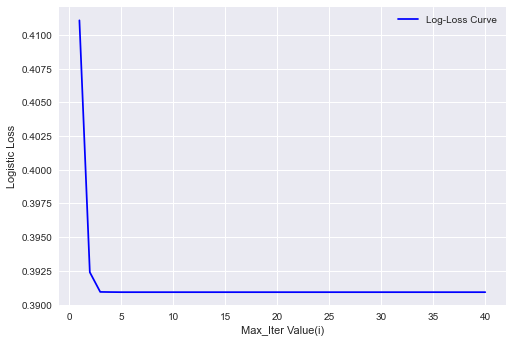

Min Logistic Loss:  0.3909239314791074
Max_Iter of min logistic loss:  4


(<Figure size 576x396 with 1 Axes>, <Figure size 576x396 with 1 Axes>)

In [159]:
myfit_logistic(x_train, y_train, x_test)

In [160]:
x_folds, y_folds = mymake_folds(5, x_train, y_train)
training_x, testing_x = pop_row(x_folds, 1)
training_y, testing_y = pop_row(y_folds, 1)
cat_X = cat(training_x)
cat_Y = cat(training_y)
C_grid = np.logspace(-9, 6, 31)
C_accuracy = []
C_loss = []
for C in C_grid:
    LRM = LogisticRegression(solver='liblinear', C=C).fit(cat_X, cat_Y)
    pred_te = LRM.predict(testing_x)
#     C_accuracy.append(clf.score(xTest,yTest))
    counter = 0.0
    for k in range(0,480):
        if testing_y[k] != pred_te[k]:
            counter += 1
    C_accuracy.append(1-counter/te_len)
    C_loss.append(sklearn.metrics.log_loss(testing_y,pred_te))
std = stats.stdev(C_accuracy)
print("Standard deviation of models:", std)

Inside mymake_folds
Standard deviation of models: 0.016854118620413843


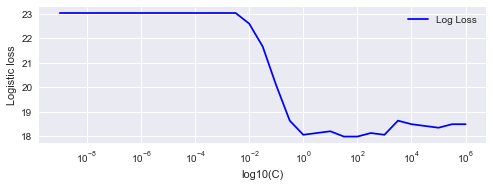

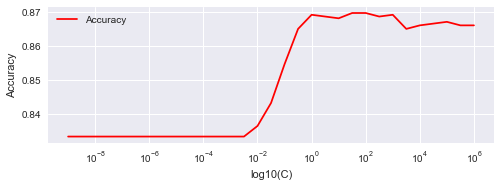

C-value with highest accuracy for LR: 31.6227766
Log-loss at best C-value: 17.9890
Accuracy with best C value: 0.8697


In [161]:
plt.subplot(211)

plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('Logistic loss')
plt.plot(C_grid,C_loss, color='blue',label = "Log Loss")

plt.legend()
plt.show()

plt.subplot(212)
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('Accuracy')
plt.plot(C_grid,C_accuracy, color='red',label = "Accuracy")

plt.legend()
plt.show()
print("C-value with highest accuracy for LR: %.7f" % C_grid[np.argmax(C_accuracy)]) # TODO
print("Log-loss at best C-value: %.4f" % min(C_loss))
print("Accuracy with best C value: %.4f" % C_accuracy[np.argmax(C_accuracy)])

In [162]:
model = LogisticRegression(solver = 'liblinear', C = 31.6227766)
model.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)
#0.50167     0.49833

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurph

Standard deviation of models: 0.00014881715487149118
done building models


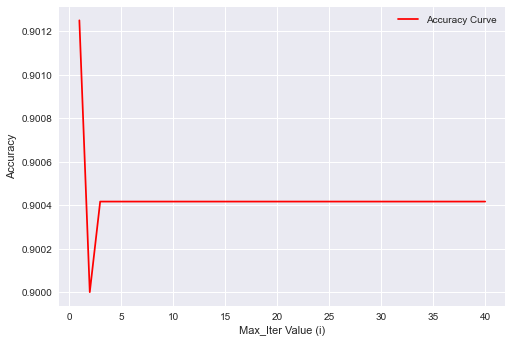

Max Accuracy Score:  0.90125
Max_Iter of max accuracy score:  0


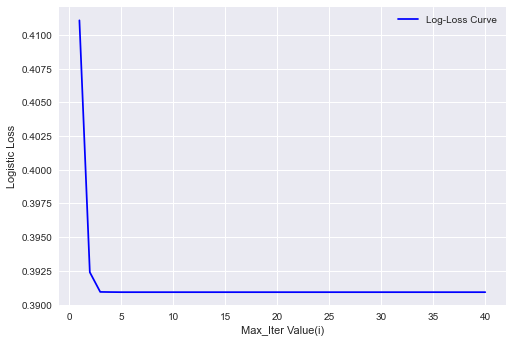

Min Logistic Loss:  0.3909239314791074
Max_Iter of min logistic loss:  4


(<Figure size 576x396 with 1 Axes>, <Figure size 576x396 with 1 Axes>)

In [163]:
myfit_logistic(x_train, y_train, x_test)

In [93]:
model = LogisticRegression(solver = 'liblinear', max_iter = 0, C = 1)
model.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [73]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

x = vectorizer.fit_transform(x_tot)
x = x.toarray()
x_train = x[:2400]
x_test = x[2400:]

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


## TFID-Bag of words

In [60]:

tfid_vectorizer = TfidfVectorizer()
x2 = tfid_vectorizer.fit_transform(x_tot)
x2 = x2.toarray()
#x_train, x_test = tr_te_split(x, leng)
x_train_2 = x2[:2400]
x_test_2 = x2[2400:]

AttributeError: 'list' object has no attribute 'lower'

In [77]:
tfid_vectorizer = TfidfVectorizer()
x2 = tfid_vectorizer.fit_transform(x_tot)
x2 = x2.toarray()
#x_train, x_test = tr_te_split(x, leng)
x_train_2 = x2[:2400]
x_test_2 = x2[2400:]
#LRM = svm.SVC(random_state=17, C=10)
'''
LRM = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=i,
        )
'''
LRM = LogisticRegression(solver = 'liblinear', max_iter = 200, C = 75)
cross_val_score(LRM, x_train_2, y_train)

array([0.50416667, 0.45833333, 0.44166667, 0.48541667, 0.45625   ])

Inside mymake_folds
Standard deviation of models: 0.014838655967774289


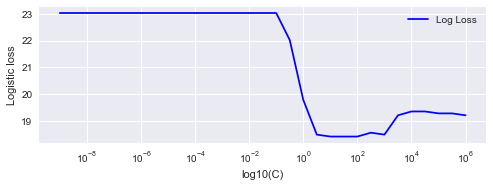

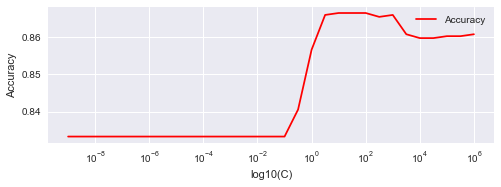

C-value with highest accuracy for LR: 10.0000000
Log-loss at best C-value: 18.4208
Accuracy with best C value: 0.8666


In [164]:
x_folds, y_folds = mymake_folds(5, x_train_2, y_train)
training_x, testing_x = pop_row(x_folds, 1)
training_y, testing_y = pop_row(y_folds, 1)
cat_X = cat(training_x)
cat_Y = cat(training_y)
C_grid = np.logspace(-9, 6, 31)
C_accuracy = []
C_loss = []
for C in C_grid:
    LRM = LogisticRegression(solver='liblinear', C=C).fit(cat_X, cat_Y)
    pred_te = LRM.predict(testing_x)
#     C_accuracy.append(clf.score(xTest,yTest))
    counter = 0.0
    for k in range(0,480):
        if testing_y[k] != pred_te[k]:
            counter += 1
    C_accuracy.append(1-counter/te_len)
    C_loss.append(sklearn.metrics.log_loss(testing_y,pred_te))
std = stats.stdev(C_accuracy)
print("Standard deviation of models:", std)
plt.subplot(211)

plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('Logistic loss')
plt.plot(C_grid,C_loss, color='blue',label = "Log Loss")

plt.legend()
plt.show()

plt.subplot(212)
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('Accuracy')
plt.plot(C_grid,C_accuracy, color='red',label = "Accuracy")

plt.legend()
plt.show()
print("C-value with highest accuracy for LR: %.7f" % C_grid[np.argmax(C_accuracy)]) # TODO
print("Log-loss at best C-value: %.4f" % min(C_loss))
print("Accuracy with best C value: %.4f" % C_accuracy[np.argmax(C_accuracy)])

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Standard deviation of models: 0.0002635231383473535
done building models


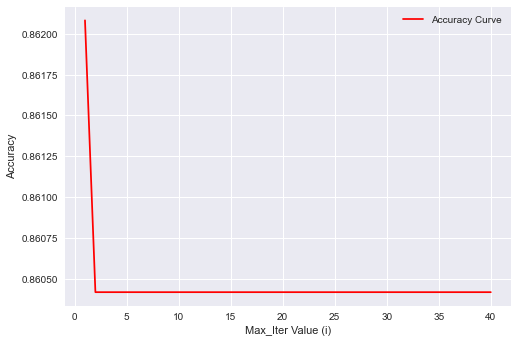

Max Accuracy Score:  0.8620833333333333
Max_Iter of max accuracy score:  0


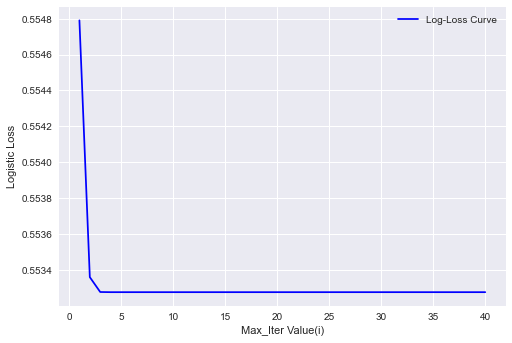

Min Logistic Loss:  0.5532774484643875
Max_Iter of min logistic loss:  3


(<Figure size 576x396 with 1 Axes>, <Figure size 576x396 with 1 Axes>)

In [165]:
myfit_logistic(x_train_2, y_train, x_test_2)

In [61]:
clf = LogisticRegression(solver='liblinear').fit(x_train, y_train)

y_te = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_te)

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: 

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: 

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

BEST SCORE: 
0.47541666666666665
STANDARD DEVIATIONS
[       nan 0.04491504        nan 0.04491504        nan 0.04491504
        nan 0.04491504        nan 0.04491504        nan 0.04491504
        nan 0.04491504        nan 0.04474077        nan 0.04551022
        nan 0.0481498         nan 0.04789673        nan 0.04938862
        nan 0.05226801        nan 0.05251323        nan 0.05266179
        nan 0.05193145        nan 0.05258261        nan 0.05317359
        nan 0.04567016        nan 0.04560549        nan 0.03537988
        nan 0.02612071        nan 0.02199274        nan 0.02095796
        nan 0.0172502         nan 0.02399363        nan 0.01765802
        nan 0.02301117        nan 0.02862594        nan 0.02687419
        nan 0.02727815]
STANDARD DEVIATION FOR BEST SCORE:
0.01725020128707037


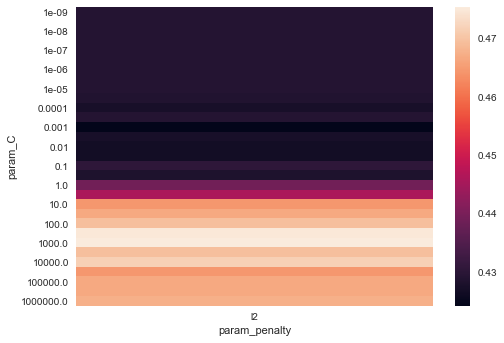

In [64]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
# Grid Search for Hyperparameters
penalty = ['l1', 'l2']
C = np.logspace(-9, 6, 31)
hyperparams = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparams, cv=5, verbose=0)
clf.fit(x_train, y_train_df)
print("BEST SCORE: ")
print(clf.best_score_)
print("STANDARD DEVIATIONS")
print(clf.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf.cv_results_['std_test_score'][clf.best_index_])
pivot = pd.pivot_table(pd.DataFrame(clf.cv_results_), values='mean_test_score', index='param_C', columns='param_penalty')
ax = sns.heatmap(pivot)

Inside mymake_folds
Almost there
Almost there
Almost there
Almost there
Almost there
Standard deviation of accuracy in models: 0.00661983454298397
Standard deviation of log-loss in models: 0.9140720998007174


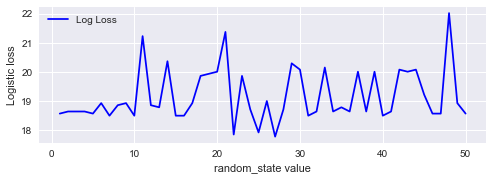

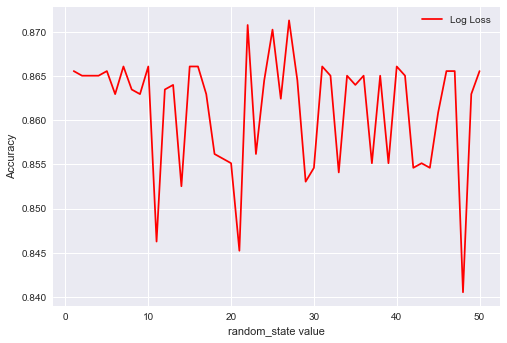

Best random_state for MLP: 27.0000000
Log-loss at best random_state: 17.7732
Accuracy under the best random_state: 0.8713
Inside mymake_folds
Almost there
Almost there
Almost there
Almost there
Almost there
Standard deviation of accuracy in models: 0.008685515758641852
Standard deviation of log-loss in models: 1.1993070296418014


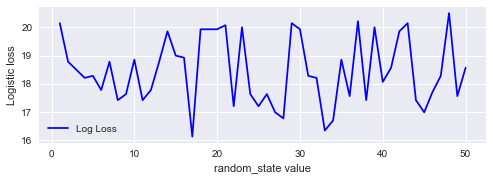

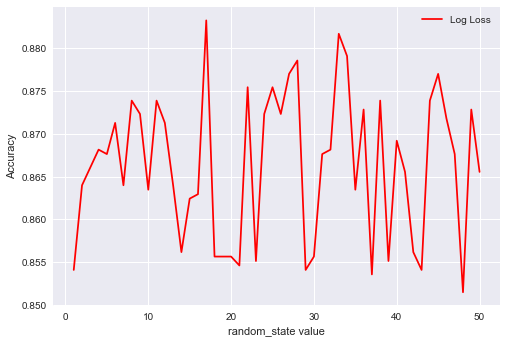

Best random_state for MLP: 17.0000000
Log-loss at best random_state: 16.1182
Accuracy under the best random_state: 0.8833


In [196]:
tfid_vectorizer = TfidfVectorizer()
x2 = tfid_vectorizer.fit_transform(x_tot)
x2 = x2.toarray()
#x_train, x_test = tr_te_split(x, leng)
x_train_2 = x2[:2400]
x_test_2 = x2[2400:]
MLP_class(x_train_2, y_train, x_test_2, 'logistic')
MLP_class(x_train_2, y_train, x_test_2, 'relu')

In [52]:
def mySVM(x_train, x_test, y_train):
    C_grid = np.logspace(-9, 6, 31)
    k=5
    penalty_acc = []
    penalty_loss = []
    start_time = time.time()
    x_folds, y_folds = mymake_folds(k, x_train, y_train)
    training_x, testing_x = pop_row(x_folds, 1)
    training_y, testing_y = pop_row(y_folds, 1)
    cat_X = cat(training_x)
    cat_Y = cat(training_y)
    wrongs = []
    i = 0
    for c in C_grid:
        print(i)
        clf = svm.SVC(random_state=17, C=c)
        clf.fit(x_train, y_train)
        test_predict = clf.predict(testing_x)
        penalty_acc.append(clf.score(testing_x,testing_y))
        penalty_loss.append(sklearn.metrics.log_loss(testing_y, test_predict))
        i+=1
    print("Runtime:", time.time() - start_time)
    std = stats.stdev(penalty_acc)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    plt.xscale('log')
    plt.xlabel('log10(C)')
    plt.ylabel('logistic loss')
    plt.plot(C_grid,penalty_loss, color='blue',label = "Log Loss")
    plt.legend()
    plt.show()
    plt.xlabel('log10(C)')
    plt.ylabel('Accuracy')
    plt.plot(C_grid, penalty_acc, color = 'red', label = 'Accuracy Curve')
    plt.legend()
    plt.show()
    print("Max Accuracy Score: ", max(penalty_acc))
    print("Max_Iter of max accuracy score: ", penalty_acc.index(max(penalty_acc)))
    print("Best C-value for LR: %.7f" % C_grid[np.argmin(penalty_loss)]) # TODO
    print("Log-loss at best C-value: %.4f" % min(penalty_loss))
    print("Accuracy of model using best C-value: %.7f" % penalty_acc[np.argmin(penalty_loss)])

Inside mymake_folds
0
1
Runtime: 55.542231798172
Standard deviation of models: 0.04419417382415922


ValueError: x and y must have same first dimension, but have shapes (31,) and (2,)

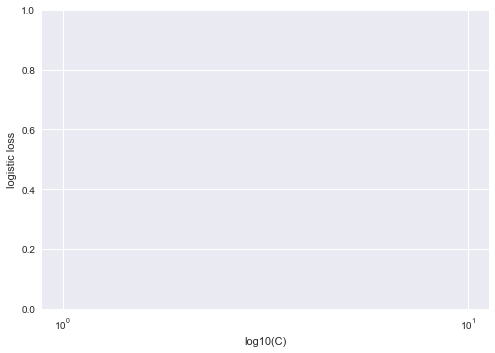

In [54]:
import time
tfid_vectorizer = TfidfVectorizer()
x2 = tfid_vectorizer.fit_transform(x_tot)
x2 = x2.toarray()
x_train_2 = x2[:2400]
x_test_2 = x2[2400:]
mySVM(x_train_2, x_test_2, y_train)

Inside mymake_folds
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Runtime: 775.3042874336243
Standard deviation of models: 0.09565834499167962


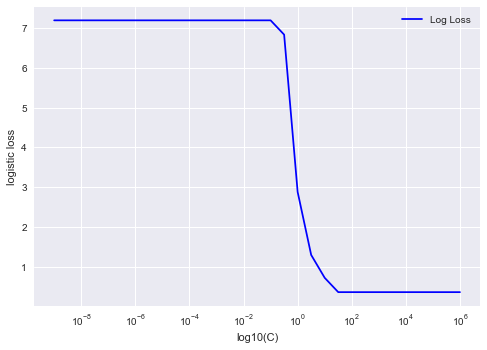

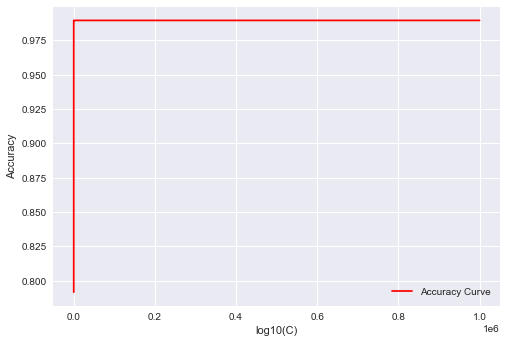

Max Accuracy Score:  0.9895833333333334
Max_Iter of max accuracy score:  21
Best C-value for LR: 31.6227766
Log-loss at best C-value: 0.3598
Accuracy of model using best C-value: 0.9895833


In [47]:
mySVM(x_train, x_test, y_train)

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

cv = CountVectorizer()
word_count_vector = cv.fit_transform(train_text_list)
print(word_count_vector.shape)


x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tr = []
vectorizer = TfidfVectorizer()
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))



# feature transform testing set
te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
print(x_train.shape, x_test.shape)
'''
x_tot = x_test_clean + x_train_clean
# SVM
tfid_vectorizer = TfidfVectorizer()
x = tfid_vectorizer.fit_transform(x_tot)
x = x.toarray()
x_train = x[:2400]
x_test = x[2400:]
'''

(2400, 4510)
(2400, 3417) (600, 3417)


'\nx_tot = x_test_clean + x_train_clean\n# SVM\ntfid_vectorizer = TfidfVectorizer()\nx = tfid_vectorizer.fit_transform(x_tot)\nx = x.toarray()\nx_train = x[:2400]\nx_test = x[2400:]\n'

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Load Data

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

cv = CountVectorizer()
word_count_vector = cv.fit_transform(train_text_list)
print(word_count_vector.shape)


x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tr = []
vectorizer = TfidfVectorizer()
for text in x_train_clean:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))



# feature transform testing set
te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
print(x_train.shape, x_test.shape)


In [101]:
svmmodel = svm.SVC(C = 31.6227766, kernel = 'sigmoid')
svmmodel.fit(x_train, y_train)
y_pred = svmmodel.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)

In [103]:
from sklearn.model_selection import cross_val_score
model = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=27,
        )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)
cross_val_score(model, x_train, y_train)

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

array([0.80416667, 0.79166667, 0.76875   , 0.76458333, 0.8       ])

## PART TWO

In [4]:
import sklearn.neighbors
from collections import OrderedDict
word_embeddings = pd.read_csv('data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)


In [5]:
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

## Try some analogies
def analogy_lookup(a1, a2, b1):
    target_vec = word2vec[a2] - word2vec[a1] + word2vec[b1]
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=7, metric='euclidean', algorithm='brute')
    knn.fit(word_embeddings.values)
    dists, indices = knn.kneighbors(target_vec[np.newaxis,:])
    print("Query: %s:%s -> %s:____" % (a1, a2, b1))
    for ii, vv in enumerate(indices[0]):
        print("   %20s  at dist %.3f" % (word_list[vv], dists[0,ii]))

analogy_lookup('england', 'london', 'france')
analogy_lookup('england', 'london', 'germany')
analogy_lookup('england', 'london', 'japan')
analogy_lookup('england', 'london', 'indonesia')

analogy_lookup('swim', 'swimming', 'run')

Query: england:london -> france:____
                  paris  at dist 3.408
                 france  at dist 4.349
               brussels  at dist 4.657
                 french  at dist 4.711
                 berlin  at dist 5.369
                 vienna  at dist 5.389
             luxembourg  at dist 5.411
Query: england:london -> germany:____
                 berlin  at dist 4.269
                germany  at dist 4.349
                 german  at dist 4.760
              frankfurt  at dist 4.913
                 moscow  at dist 5.014
                 vienna  at dist 5.062
                 warsaw  at dist 5.201
Query: england:london -> japan:____
                  tokyo  at dist 3.900
                  japan  at dist 4.349
               japanese  at dist 4.569
               shanghai  at dist 4.941
                  seoul  at dist 5.299
                beijing  at dist 5.348
              singapore  at dist 5.498
Query: england:london -> indonesia:____
              singapore  at di

In [157]:
# Load Data
import pandas as pd
import numpy as np

from collections import OrderedDict

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


train_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tot = x_test_clean + x_train_clean
word_embeddings = pd.read_csv('data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))


In [158]:
vectorizer = TfidfVectorizer()
x_tr_pre = preprocess(tr_text_list)
x_tr = []
for text in x_tr_pre:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
print(x_train.shape, x_test.shape)

(2400, 3417) (600, 3417)


In [159]:
k = 5
mlp_lbfgs = MLPClassifier(
                hidden_layer_sizes=[2],
                activation='relu',
                alpha=0.0001,
                max_iter=200, tol=1e-6,
                random_state=3,
                )
mlp_lbfgs.fit(x_train, y_train_df.values.ravel())
y_pred = mlp_lbfgs.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)
# 0.23, 0.77

/Users/nickmurphy/miniconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Load Data
import pandas as pd
import numpy as np

from collections import OrderedDict

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


tr_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tot = x_test_clean + x_train_clean
word_embeddings = pd.read_csv('data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

vectorizer = TfidfVectorizer()
x_tr_pre = preprocess(tr_text_list)
x_tr = []
for text in x_tr_pre:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
clf = svm.SVC(random_state=3)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)
# 0.15833, 0.84167

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Load Data
import pandas as pd
import numpy as np

from collections import OrderedDict

x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
x_test_df = pd.read_csv('data/data_reviews/x_test.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')


tr_text_list = x_train_df['text'].values.tolist()
test_text_list = x_test_df['text'].values.tolist()
train_label_list = x_train_df['website_name'].values.tolist()
test_label_list = x_test_df['website_name'].values.tolist()
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
y_train = np.loadtxt('./data/data_reviews/y_train.csv', delimiter=',', skiprows=1)

x_test_clean = preprocess(test_text_list)
x_train_clean = preprocess(train_text_list)
x_tot = x_test_clean + x_train_clean
word_embeddings = pd.read_csv('data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

vectorizer = TfidfVectorizer()
x_tr_pre = preprocess(tr_text_list)
x_tr = []
for text in x_tr_pre:
    sentence = " ".join(text)
    x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
    sentence = " ".join(text)
    x_te.append(sentence)
x_test = vectorizer.transform(x_te)
clf = svm.SVC(random_state=3)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
np.savetxt('yproba1_test.txt', y_pred)

Standard deviation of models: 0.14632646060890242


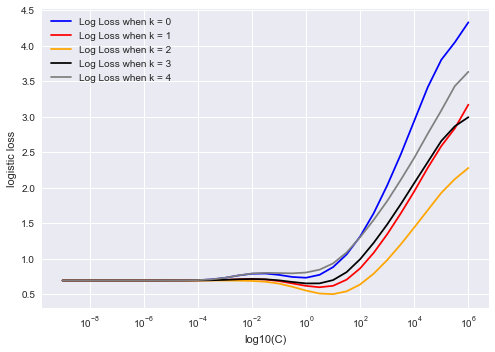

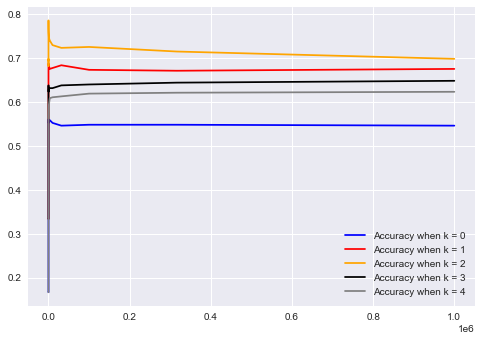

Best C-value for LR: 0.0000000
Log-loss at best C-value: 0.5008
Accuracy of model using best C-value: 0.7854167


In [138]:
myfind_best_pen(x_train, y_train, x_test)

Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Standard deviation of models: 0.006548116236843003


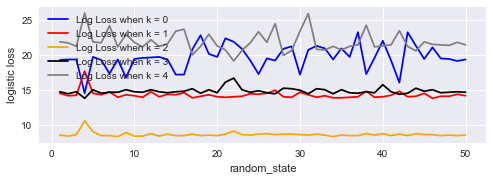

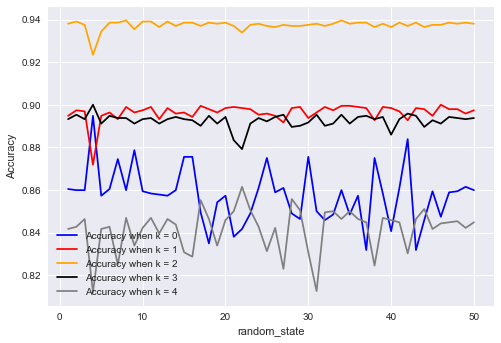

Best random_state for MLP: 3.0000000
Log-loss at best random_state: 8.3469
Accuracy under the best random_state: 0.9396


In [139]:
MLP_class(x_train, y_train, x_test, 'logistic')

Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Almost there 0
Almost there 10
Almost there 20
Almost there 30
Almost there 40
Standard deviation of models: 0.014944164030228363


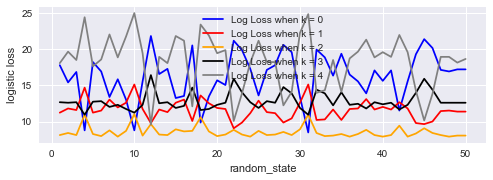

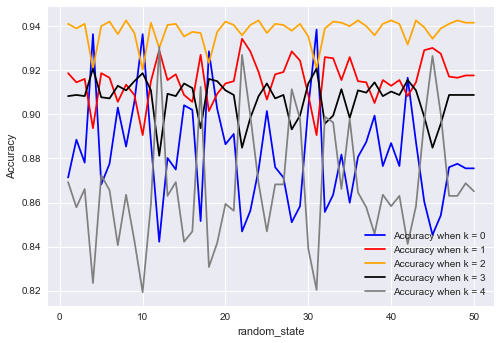

Best random_state for MLP: 3.0000000
Log-loss at best random_state: 7.9152
Accuracy under the best random_state: 0.9427


In [142]:
MLP_class(x_train, y_train, x_test, 'relu')

cunt
cunt
cunt
cunt
cunt
Standard deviation of models: 0.15851537555280992


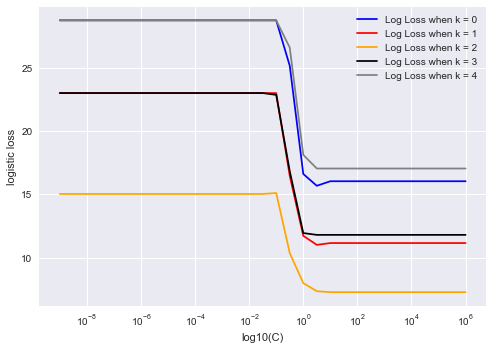

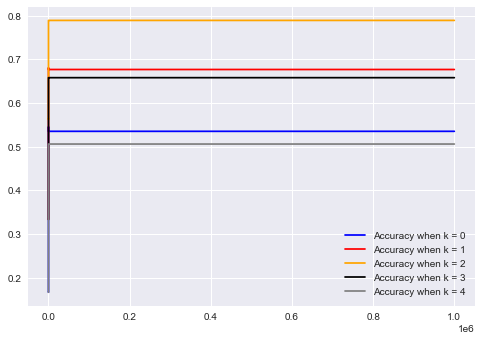

Best C-value for SVM: 0.0000000
Log-loss at best C-value: 7.2676
Accuracy of model using best C-value: 0.7895833


In [147]:
mySVM2(x_train, x_test, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1, 2400]

In [3]:
def MLP_class(x_train, y_train, x_test, activation):
    X = x_train
    y = y_train
    stds = []
    penalty_acc = []
    penalty_loss = []
    stds = []
    k = 5
    n_runs = 50
    kf = KFold(n_splits=k, random_state=None)
    for train_index , test_index in kf.split(X):
        x_train , x_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        LBFGS_RELU_loss = []
        LBFSG_RELU_res = []
        LBFGS_RELU_i = []
        mod_accuracy = []
        mod_loss = []
        for i in range(n_runs):
            mlp_lbfgs = MLPClassifier(
                hidden_layer_sizes=[2],
                activation=activation,
                alpha=0.0001,
                max_iter=200, tol=1e-6,
                random_state=i,
                )
            if i % 10 == 0:
                print("Almost there", i)
            with warnings.catch_warnings(record=True) as warn_list:
                mlp_lbfgs.fit(x_train, y_train)
            y_pred = mlp_lbfgs.predict(x_test)
            counter = 0.0
            for r in range(len(y_test)):
                if y_test[r] != y_pred[r]:
                    counter += 1
            LBFSG_RELU_res.append(1-counter/x_train.shape[0])
            LBFGS_RELU_loss.append(sklearn.metrics.log_loss(y_test,y_pred))
        penalty_acc.append(LBFSG_RELU_res)
        penalty_loss.append(LBFGS_RELU_loss)
        std = stats.stdev(LBFSG_RELU_res)
        stds.append(std)
    plt.subplot(211)
    rands = [_ for _ in range(1,51)]
    std = stats.mean(stds)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    mins = find_min(penalty_loss)
    maxs = find_max(penalty_acc)
    plt.xlabel('random_state')
    plt.ylabel('logistic loss')
    plt.plot(rands,penalty_loss[0], color='blue',label = "Log Loss when k = 0")
    plt.plot(rands,penalty_loss[1], color='red',label = "Log Loss when k = 1")
    plt.plot(rands,penalty_loss[2], color='orange',label = "Log Loss when k = 2")
    plt.plot(rands,penalty_loss[3], color='black',label = "Log Loss when k = 3")
    plt.plot(rands,penalty_loss[4], color='grey',label = "Log Loss when k = 4")
    plt.legend()
    plt.show()
    plt.xlabel('random_state')
    plt.ylabel('Accuracy')
    plt.plot(rands,penalty_acc[0], color='blue',label = "Accuracy when k = 0")
    plt.plot(rands,penalty_acc[1], color='red',label = "Accuracy when k = 1")
    plt.plot(rands,penalty_acc[2], color='orange',label = "Accuracy when k = 2")
    plt.plot(rands,penalty_acc[3], color='black',label = "Accuracy when k = 3")
    plt.plot(rands,penalty_acc[4], color='grey',label = "Accuracy when k = 4")
    plt.legend()
    plt.show()
    print("Best random_state for MLP: %.7f" % rands[np.argmax(maxs)]) # TODO
    print("Log-loss at best random_state: %.4f" % min(mins))
    print("Accuracy under the best random_state: %.4f" % maxs[np.argmax(maxs)])

NameError: name 'myfind_best_pen' is not defined

In [20]:
def vectorizer(sentence):
    sent_vec = np.zeros(50)
    numw = 0
    for w in sentence:
        try: 
            vc = word2vec[w]
            print(vc)
            print("ligma")
            vc = [i * tfidf[w] for i in vc]
            print(vc)
            print("ligma")
            vc=vc[0:50]
            print(vc)
            print("ligma")
            sent_vec = np.add(sent_vec, vc)
            numw+=1
        except:
            pass
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

In [132]:
te_text_list = x_test_df['text'].values.tolist()
tr_text_list = x_train_df['text'].values.tolist()
X_train_pre = []
for sentence in preprocess(tr_text_list):
    X_train_pre.append(vectorizer(sentence))

X_train = []
for sentence in X_train_pre:
    arr = []
    for word in sentence:
        if np.isnan(word):
            arr.append(0)
        else:
            arr.append(word)
        X_train.append(arr)

x_train = np.array(X_train)

X_test_pre = []

for sentence in preprocess(te_text_list):
    X_test_pre.append(vectorizer(sentence))

X_test = []
for sentence in X_test_pre:
    arr = []
    for word in sentence:
        if np.isnan(word):
            arr.append(0)
        else:
            arr.append(word)
    X_test.append(arr)

x_test = np.array(X_test)

TypeError: 'TfidfVectorizer' object is not callable

In [138]:
print(y_train.shape)

(2400,)


In [139]:
print(x_train.shape)

(120000, 50)


## Logistic Regression

In [130]:
def myfit_logistic(x_train, y_train, x_test):
    acc_scores = []
    log_loss = []
    weights = []
    for max_iter in range(1,41):
        model = LogisticRegression(solver = 'liblinear', max_iter = max_iter, C = 1.000).fit(x_train, y_train_df)
        weights.append(model.coef_[0][0])
        acc_scores.append(model.score(x_train, y_train))
        y_pred = model.predict_proba(x_train)
        log_loss.append(sklearn.metrics.log_loss(y_train, y_pred))
    std = stats.stdev(acc_scores)
    print("Standard deviation of models:", std)
    print("done building models")
    acc = plt.figure()
    plt.xlabel('Max_Iter Value (i)')
    plt.ylabel('Accuracy')
    plt.plot([_ for _ in range(1,41)], acc_scores, color = 'red', label = 'Accuracy Curve')
    plt.legend()
    plt.show()
    print("Max Accuracy Score: ", max(acc_scores))
    print("Max_Iter of max accuracy score: ", acc_scores.index(max(acc_scores)))
    
    loss = plt.figure()
    plt.xlabel('Max_Iter Value(i)')
    plt.ylabel('Logistic Loss')
    plt.plot([_ for _ in range(1,41)],log_loss, color='blue',label = "Log-Loss Curve")
    plt.legend()
    plt.show()
    print("Min Logistic Loss: ", min(log_loss))
    print("Max_Iter of min logistic loss: ", log_loss.index(min(log_loss)))
    return acc, loss

In [166]:
def pop_row2(arr, index):
    popped = arr[index]
    result = np.array(arr[:index] + arr[index + 1:])
    
    #result = np.vstack((arr[:index], arr[index + 1:]))
    return result, popped

In [167]:
def myfind_best_pen(x_train, y_train, x_test):
    C_grid = np.logspace(-9, 6, 31)
    k=5
    penalty_acc = []
    penalty_loss = []
    x_folds, y_folds = mymake_folds2(k, x_train, y_train)
    training_x, testing_x = pop_row2(x_folds, 1)
    training_y, testing_y = pop_row2(y_folds, 1)
    cat_X = cat(training_x)
    cat_Y = cat(training_y)
    for C in C_grid:
        model_2 = LogisticRegression(solver='liblinear', C=C).fit(cat_X, cat_Y)
        test_predict = model_2.predict_proba(testing_x)
        penalty_acc.append(model_2.score(testing_x,testing_y))
        penalty_loss.append(sklearn.metrics.log_loss(testing_y, test_predict))
    
    std = stats.stdev(penalty_acc)
    print("Standard deviation of models:", std)
    C_grid = np.logspace(-9, 6, 31)
    plt.xscale('log')
    plt.xlabel('log10(C)')
    plt.ylabel('logistic loss')
    plt.plot(C_grid,penalty_loss, color='blue',label = "Log Loss")
    plt.legend()
    plt.show()
    print("Best C-value for LR: %.7f" % C_grid[np.argmin(penalty_loss)]) # TODO
    print("Log-loss at best C-value: %.4f" % min(penalty_loss))
    print("Accuracy of model using best C-value: %.7f" % penalty_acc[np.argmin(penalty_loss)])

In [182]:
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
acc_score = []
X = x_train
y = y_train
for train_index , test_index in kf.split(X):
    X_train , X_test = X[train_index,:],X[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

IndexError: index 1920 is out of bounds for axis 0 with size 1920

In [214]:
def find_best_pen_cross(x_train, x_test, y_train):
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    C_grid = np.logspace(-9, 6, 31)
    X = x_train
    y = y_train
    for train_index , test_index in kf.split(X):
        X_train , X_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        penalty_acc = []
        penalty_loss = []
        for C in C_grid:
            model_2 = LogisticRegression(solver='liblinear', C=C).fit(X_train, y_train)
            test_predict = model_2.predict_proba(X_test)
            penalty_acc.append(model_2.score(X_test,y_test))
            penalty_loss.append(sklearn.metrics.log_loss(y_test, test_predict)) 
    std = stats.stdev(penalty_acc)
    print("Standard deviation of models:", std)
    plt.xscale('log')
    plt.xlabel('log10(C)')
    plt.ylabel('logistic loss')
    plt.plot(C_grid,penalty_loss, color='blue',label = "Log Loss")
    plt.legend()
    plt.show()
    print("Best C-value for LR: %.7f" % C_grid[np.argmax(penalty_acc)]) # TODO
    print("Log-loss at best C-value: %.4f" % min(penalty_loss))
    print("Accuracy of model using best C-value: %.7f" % penalty_acc[np.argmax(penalty_acc)])

In [215]:
def mymake_folds2(num_folds,x_train, y_train):
    print("Inside mymake_folds")
    i = 0
    step = int(x_train.shape[0] / num_folds)
    x_folds = list()
    y_folds = list()
    for k in range(num_folds):
        x_folds.append(x_train[i:i+step])
        y_folds.append(y_train[i:i+step])
        i += step
    
    # TODO: Complete method to generate partition into folds.
    
    return np.array(x_folds), np.array(y_folds)

Standard deviation of models: 0.2037898605745605


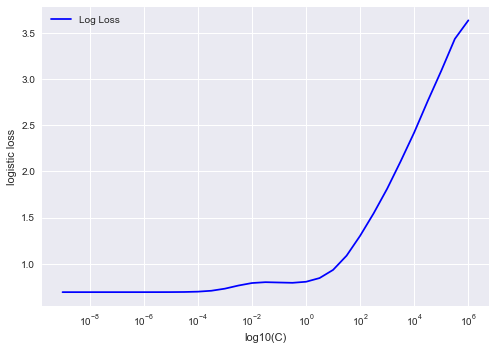

Best C-value for LR: 1000000.0000000
Log-loss at best C-value: 0.6931
Accuracy of model using best C-value: 0.6229167


In [216]:
find_best_pen_cross(x_train, x_test, y_train)

## MLP

## SVM